In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [2]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [4]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [5]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

/tmp/ipykernel_12385/3303076186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)


# Train and evaluate the number of arms extractor

In [6]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [7]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [8]:
number_words = {"both":2, "either":2, "one":1, "two":2, "three":3, "four":4, "five":5}
for i in range(1, 10):
    number_words[str(i)] = i

In [14]:
arms_regex = re.compile(r'(?i)(' + "|".join(number_words) + r')?(treatment|study|dose)?\s*(arm|group|subgroup|cohort)s?')

In [15]:
def predict_arms_rule_based(text):
    matches = arms_regex.findall(text)
    max_arms = 0
    for m in matches:
        for n in number_words:
            if n in m:
                num_arms = number_words[n.lower()]
                if num_arms > max_arms:
                    max_arms = num_arms
    if max_arms > 5:
        max_arms = 5
    if max_arms == 0:
        max_arms = 2 # fallback
    return max_arms

In [16]:
pred_num_arms = df_val.text.apply(predict_arms_rule_based)

In [21]:
num_arms_ground_truths = df_val.num_arms_clean

In [22]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.2821969696969697


''

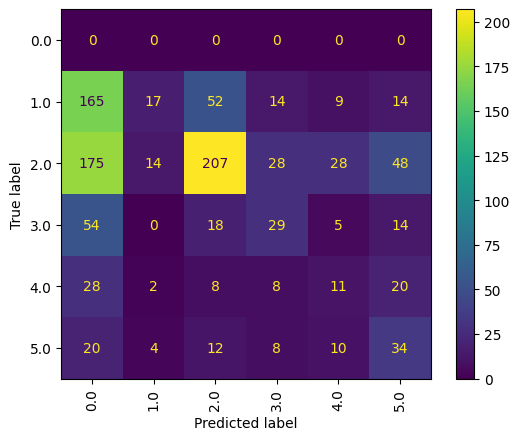

In [23]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;